In [ ]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33955")
client

In [3]:
client.restart()

<Client: 'tcp://127.0.0.1:43605' processes=0 threads=0, memory=0 B>

In [29]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import gsw
import xrft
import xwavelet
from scipy.interpolate import interp2d, bisplrep, bisplev, griddata
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/Wavelet-spectrum/'
topog = '/tank/topog/tuchida/TWA/'
tdgs = '/tank/tdgs/tuchida/TWA'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1421280,1576800+dnf,dnf).reshape(len(years),nfile)
dd = 0  
yystart = 0
ntimes[yystart,:]

array([1421280, 1423440, 1425600, 1427760, 1429920, 1432080, 1434240,
       1436400, 1438560, 1440720, 1442880, 1445040, 1447200, 1449360,
       1451520, 1453680, 1455840, 1458000, 1460160, 1462320, 1464480,
       1466640, 1468800, 1470960, 1473120, 1475280, 1477440, 1479600,
       1481760, 1483920, 1486080, 1488240, 1490400, 1492560, 1494720,
       1496880, 1499040, 1501200, 1503360, 1505520, 1507680, 1509840,
       1512000, 1514160, 1516320, 1518480, 1520640, 1522800, 1524960,
       1527120, 1529280, 1531440, 1533600, 1535760, 1537920, 1540080,
       1542240, 1544400, 1546560, 1548720, 1550880, 1553040, 1555200,
       1557360, 1559520, 1561680, 1563840, 1566000, 1568160, 1570320,
       1572480, 1574640, 1576800])

In [6]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]

In [50]:
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
xchunk = 100
ychunk = 100

ng = 3

yy = yystart

for reg in range(len(xs)-5):
    for year in years[yystart:]:
        if year == years[yystart]:
            mtimes = ntimes[yy,:dd+3]
        else:
            mtimes = ntimes[yy]
        
        for itime in mtimes:
            if itime == mtimes[0]:
                dsb = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Ensemble-mean/%2dmembers/15N-50N_%010d.zarr'
                                           % (year,len(nmembs),itime))
                                  ).isel(time=0
                                        ).sel(YC=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                              YG=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                              XC=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12),
                                              XG=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12)
                                             ).chunk({'Z':4,'Zl':4,'Zu':4,'Zp1':4})
            else:
                dsb = xr.concat([dsb, xr.open_zarr(op.join(tdgs,
                                                        '5Dave/run%4d/Ensemble-mean/%2dmembers/15N-50N_%010d.zarr'
                                                  % (year,len(nmembs),itime))
                                                         ).isel(time=0
                                                 ).sel(YC=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                                       YG=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                                       XC=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12),
                                                       XG=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12)
                                                      ).chunk({'Z':4,'Zl':4,'Zu':4,'Zp1':4})
                                ], dim='time')
        
        for nmemb in nmembs:
            if nmemb == 0:
                ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                             % (nmemb,year)), 
                                     grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                     prefix=['diag_ocnTave'], delta_t=2e2,
                                     iters=mtimes, 
                                    ).sel(YC=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                          YG=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                          XC=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12),
                                          XG=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12)
                                         )
#                 print(ds)
            else:
#                 if nmemb == 36:
#                     print(open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
#                                                   % (nmemb,year)), 
#                                           grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
#                                           prefix=['diag_ocnTave'], delta_t=2e2,
#                                           iters=mtimes, 
#                                          )
#                          )
                ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                            % (nmemb,year)), 
                                                    grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                    prefix=['diag_ocnTave'], delta_t=2e2,
                                                    iters=mtimes, 
                                                   ).sel(YC=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                                         YG=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                                         XC=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12),
                                                         XG=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12)
                                                        )
                               ], dim='nmemb')
        
        phi0 = xr.open_zarr(op.join(topog,'PHI_5Dave/run%4d/%010d/' % (year,mtimes[0])),
                           ).isel(time=0
                                 ).sel(YC=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                       XC=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12)
                                      ).PHIHYD
        phi1 = xr.open_zarr(op.join(topog,'PHI_5Dave/run%4d/%010d/' % (year,mtimes[1])),
                           ).isel(time=0
                                 ).sel(YC=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                       XC=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12)
                                      ).PHIHYD
        phi2 = xr.open_zarr(op.join(topog,'PHI_5Dave/run%4d/%010d/' % (year,mtimes[2])),
                           ).isel(time=0
                                 ).sel(YC=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                                       XC=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12)
                                      ).PHIHYD
        phi = xr.concat([phi0,phi1], dim='time')
        phi = xr.concat([phi,phi2], dim='time')
        phi.coords['time'] = ds.time
        phi = xr.concat([phi, ds.PHIHYD.isel(nmemb=slice(24,None))], dim='nmemb')
        phi.coords['nmemb'] = ('nmemb',nmembs)
        print(phi)
                    
        ds.coords['nmemb'] = ('nmemb',nmembs)
        dsb.coords['time'] = ds.time

/tank/users/tuchida/xmitgcm/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/tank/users/tuchida/xmitgcm/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/tank/users/tuchida/xmitgcm/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/tank/users/tuchida/xmitgcm/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'all':
/tank/users/tuchida/xmitgcm/xmitgcm/mds_store.py:196: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if iters == 'a

<xarray.DataArray 'PHIHYD' (time: 3, nmemb: 48, Z: 46, YC: 126, XC: 122)>
dask.array<concatenate, shape=(3, 48, 46, 126, 122), dtype=float64, chunksize=(1, 24, 46, 88, 77), chunktype=numpy.ndarray>
Coordinates: (12/14)
    Depth    (YC, XC) float32 5.422e+03 5.415e+03 ... 4.406e+03 4.444e+03
    PHrefC   (Z) float32 29.89 92.74 160.5 ... 5.273e+04 5.518e+04 5.764e+04
  * XC       (XC) float32 289.8 289.9 290.0 290.1 ... 300.0 300.0 300.1 300.2
  * YC       (YC) float32 31.75 31.83 31.92 32.0 ... 41.92 42.0 42.08 42.17
  * Z        (Z) float32 -3.047 -9.454 -16.36 ... -5.625e+03 -5.875e+03
    drF      (Z) float32 6.094 6.721 7.099 7.971 ... 248.9 249.6 249.9 250.5
    ...       ...
    maskC    (Z, YC, XC) bool True True True True ... False False False False
    maskInC  (YC, XC) bool True True True True True ... True True True True True
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
    rA       (YC, XC) float32 7.538e+07 7.538e+07 ... 6.57e+07 6.57e+

In [51]:
grid = Grid(ds, periodic=[])
xA = (ds.dyG * ds.drF).reset_coords(drop=True)
yA = (ds.dxG * ds.drF).reset_coords(drop=True)

# Total $U_t$

In [52]:
u = ds.UVEL.where(ds.maskW!=0.).reset_coords(drop=True).chunk({'time':1,'nmemb':12,'Z':4})
v = ds.VVEL.where(ds.maskS!=0.).reset_coords(drop=True).chunk({'time':1,'nmemb':12,'Z':4})
w = ds.WVEL.reset_coords(drop=True).chunk({'time':1,'nmemb':12,'Zl':4})
phi = phi.where(ds.maskC!=0.).reset_coords(drop=True).chunk({'time':1,'nmemb':12,'Z':4})

/tank/users/tuchida/miniconda3/envs/py39/lib/python3.9/site-packages/dask/array/core.py:4369: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/tank/users/tuchida/miniconda3/envs/py39/lib/python3.9/site-packages/dask/array/core.py:4369: PerformanceWarning: Increasing number of chunks by factor of 24
  result = blockwise(
/tank/users/tuchida/miniconda3/envs/py39/lib/python3.9/site-packages/dask/array/core.py:4369: PerformanceWarning: Increasing number of chunks by factor of 24
  result = blockwise(


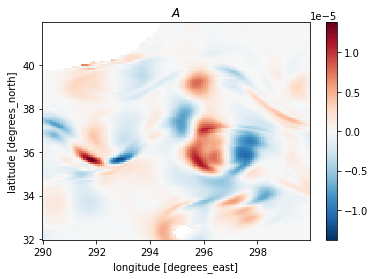

In [53]:
utTrans = ds.UVEL.where(ds.maskW!=0.).reset_coords(drop=True) * xA
vtTrans = ds.VVEL.where(ds.maskS!=0.).reset_coords(drop=True) * yA
rtTrans = grid.interp((ds.WVEL*ds.rA).reset_coords(drop=True),'X',boundary='extend')
AuuT = (grid.interp(utTrans,'X',boundary='extend')
        * grid.interp(u,'X',boundary='extend')
)
AvuT = (grid.interp(vtTrans,'X',boundary='extend')
        * grid.interp(u,'Y',boundary='extend')
)
AwuT = (rtTrans
        * grid.interp(u,'Z',boundary='extend')
)

Au = ((grid.diff(AuuT,'X',boundary='extend')
       + grid.diff(AvuT,'Y',boundary='extend')
       - grid.diff(AwuT,'Z',boundary='extend')
) / ds.drF/ds.rAw).isel(Z=[14,24],YC=slice(ng,-ng),XG=slice(ng,-ng))

fig, ax = plt.subplots()
Au.isel(nmemb=0,time=1,Z=0).plot(ax=ax)
ax.set_title(r"$A$")
plt.show()      

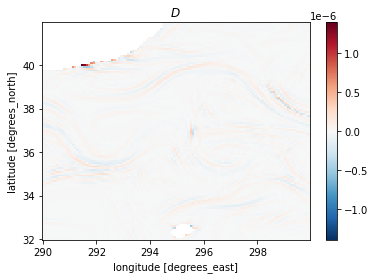

In [54]:
cosFacU = np.cos(ds.YC*2*np.pi/360.)
cosFacV = np.cos(ds.YG*2*np.pi/360.)
        
fZon = (ds.drF*ds.hFacC
        *grid.interp(ds.dyG,'X',boundary='fill')
        *grid.interp(ds.dxG,'Y',boundary='fill')**-1
        *grid.diff(u,'X',boundary='extend')
)
        
fMer = (ds.drF*grid.interp(ds.hFacW,'Y',boundary='fill')
        *grid.interp(ds.dxG,'X',boundary='fill')
        *grid.interp(ds.dyG,'Y',boundary='fill')**-1
        *grid.diff(u,'Y',boundary='fill')
)
        
del2u = (ds.drF**-1*ds.hFacW**-1
         *ds.rAw**-1
         *( grid.diff(fZon,'X',boundary='extend')
           +grid.diff(fMer,'Y',boundary='extend')
          ).where(ds.maskW!=0.)
)

xViscFluxU = (grid.interp(ds.dyG,'X',boundary='fill')*ds.drF*ds.hFacC
          *(
            -Kh*grid.diff(u,'X',boundary='extend')
            *cosFacU
            +K4*grid.diff(del2u,'X',boundary='extend')
            *cosFacU
           )*grid.interp(ds.dxG,'Y',boundary='fill')**-1
)
        
yViscFluxU = (grid.interp(ds.dxG,'X',boundary='extend')
                      *ds.drF*grid.interp(ds.hFacW,'Y',boundary='fill')
          *(
            -Kh*grid.diff(u,'Y',boundary='extend')
            +K4*grid.diff(del2u,'Y',boundary='extend')
           )*grid.interp(ds.dyG,'Y',boundary='extend')**-1
)
#################################       
        
Du_h = -((grid.diff(xViscFluxU,'X',boundary='extend') 
           + grid.diff(yViscFluxU,'Y',boundary='extend') 
) / ds.rAw/ds.drF).reset_coords(drop=True)

Du_v = (grid.diff(grid.diff(u,'Z',boundary='extend',to='outer')
                            / ds.drC*ds.rAw,
                  'Z',boundary='extend'
                 ) / ds.drF/ds.rAw
).reset_coords(drop=True) * Kr

Du = (Du_h + Du_v).isel(Z=[14,24],YC=slice(ng,-ng),XG=slice(ng,-ng))

fig, ax = plt.subplots()
Du.isel(nmemb=0,time=1,Z=0).plot(ax=ax)
ax.set_title(r"$D$")
plt.show()

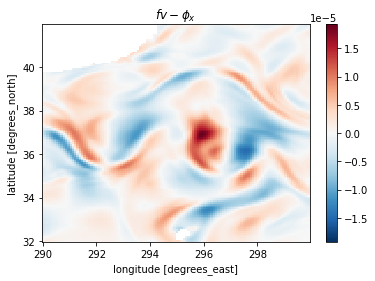

In [63]:
phi_x = (grid.diff(phi,'X',boundary='extend')
         / ds.dxC
).reset_coords(drop=True).isel(Z=[14,24],YC=slice(ng,-ng),XG=slice(ng,-ng))

f = gsw.f(ds.YC)
fv = f*grid.interp(grid.interp(v,'Y',boundary='extend'),'X',boundary='extend'
                  ).isel(Z=[14,24],YC=slice(ng,-ng),XG=slice(ng,-ng))
fig, ax = plt.subplots()
(fv-phi_x).isel(nmemb=0,time=1,Z=0).plot(ax=ax)
ax.set_title(r"$fv - \phi_x$")
plt.show()

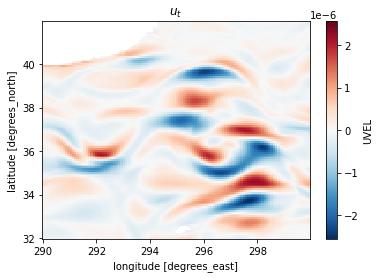

In [56]:
u_t = u.isel(Z=[14,24],YC=slice(ng,-ng),XG=slice(ng,-ng)
            ).diff('time',n=2) / (5*86400.)
fig, ax = plt.subplots()
u_t.isel(nmemb=0,time=0,Z=0).plot(ax=ax)
ax.set_title(r"$u_t$")
plt.show()

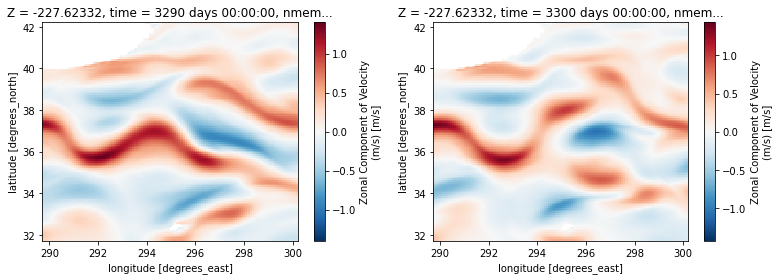

In [61]:
fig, (ax1,ax2) = plt.subplots(figsize=(11,4), nrows=1, ncols=2)
fig.set_tight_layout(True)
u.isel(nmemb=0,time=0,Z=14).plot(ax=ax1)
u.isel(nmemb=0,time=2,Z=14).plot(ax=ax2)

Text(0.5, 1.0, 'Metric')

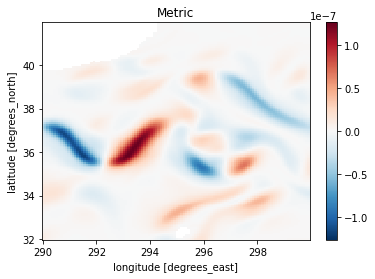

In [59]:
rSphere = 6.37e6
tanPhiAtU = np.tan(ds.YC*2*np.pi/360.)
uMetric = (
         u*rSphere**-1
         *( grid.interp(grid.interp(v,'X',boundary='extend'),'Y',boundary='extend')
          )*tanPhiAtU
).isel(Z=[14,24],YC=slice(ng,-ng),XG=slice(ng,-ng))

fig, ax = plt.subplots()
uMetric.isel(nmemb=0,time=1,Z=0).plot(ax=ax)
ax.set_title(r"Metric")

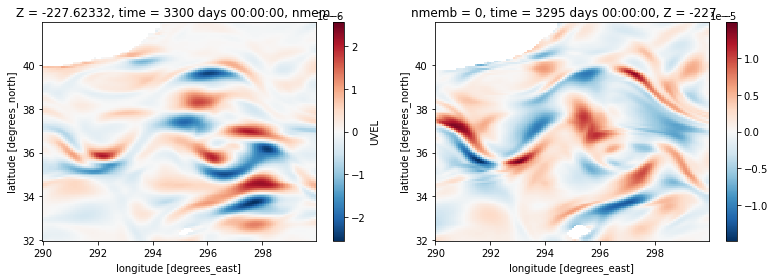

In [60]:
fig, (ax1,ax2) = plt.subplots(figsize=(11,4), nrows=1, ncols=2)
fig.set_tight_layout(True)
u_t.isel(nmemb=0,time=0,Z=0).plot(ax=ax1)
(-Au + fv - phi_x + Du + uMetric).isel(nmemb=0,time=1,Z=0).plot(ax=ax2)

# Eddy KE

In [8]:
ub = dsb.UVEL.where(ds.maskW!=0.).reset_coords(drop=True)
vb = dsb.VVEL.where(ds.maskS!=0.).reset_coords(drop=True)
wb = dsb.WVEL.reset_coords(drop=True)
up = (ds.UVEL.where(ds.maskW!=0.) - ub).reset_coords(drop=True).load().chunk({'time':1,'nmemb':12,'Z':4})
vp = (ds.VVEL.where(ds.maskS!=0.) - vb).reset_coords(drop=True).load().chunk({'time':1,'nmemb':12,'Z':4})
wp = (ds.WVEL - wb).reset_coords(drop=True).load().chunk({'time':1,'nmemb':12,'Zl':4})
phip = (phi - phi.mean('nmemb',skipna=True)
               ).where(ds.maskC!=0.).reset_coords(drop=True).load().chunk({'time':1,'nmemb':12,'Z':4})
            
#         up_t = grid.interp(up.diff('time'),'X',boundary='extend'
#                           ).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng)) / (5*86400.)
#         vp_t = grid.interp(vp.diff('time'),'Y',boundary='extend'
#                           ).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng)) / (5*86400.)
        
#         ub = ub.mean('time',skipna=True)
#         vb = vb.mean('time',skipna=True)
#         wb = wb.mean('time',skipna=True)
#         up = up.mean('time',skipna=True)
#         vp = vp.mean('time',skipna=True)
#         wp = wp.mean('time',skipna=True)
#         phip = phip.mean('time',skipna=True)
        
#         phip_z = grid.interp(-grid.diff(phip,'Z',boundary='extend',to='outer') 
#                              / ds.drC,
#                              'Z',boundary='extend'
#                             ).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng))

/tank/users/tuchida/miniconda3/envs/py39/lib/python3.9/site-packages/dask/array/core.py:4369: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/tank/users/tuchida/miniconda3/envs/py39/lib/python3.9/site-packages/dask/array/core.py:4369: PerformanceWarning: Increasing number of chunks by factor of 24
  result = blockwise(
/tank/users/tuchida/miniconda3/envs/py39/lib/python3.9/site-packages/dask/array/core.py:4369: PerformanceWarning: Increasing number of chunks by factor of 24
  result = blockwise(
/tank/users/tuchida/miniconda3/envs/py39/lib/python3.9/site-packages/dask/array/core.py:4369: PerformanceWarning: Increasing number of chunks by factor of 24
  result = blockwise(
/tank/users/tuchida/miniconda3/envs/py39/lib/python3.9/site-packages/dask/array/core.py:4369: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
/tank/users/tuchida/miniconda3/envs/py39/lib/python3.9/site-packages/dask/array/core.py:4369: Perfor

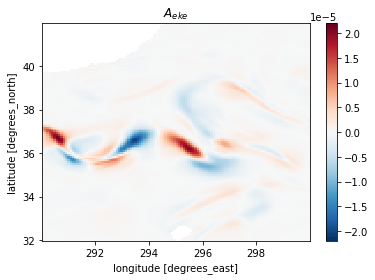

In [12]:
xA = (ds.dyG * ds.drF).reset_coords(drop=True)
yA = (ds.dxG * ds.drF).reset_coords(drop=True)
utTrans = ds.UVEL.where(ds.maskW!=0.).reset_coords(drop=True) * xA
vtTrans = ds.VVEL.where(ds.maskS!=0.).reset_coords(drop=True) * yA
rtTrans = grid.interp(ds.WVEL.reset_coords(drop=True),'X',boundary='extend') * ds.rAw
AuuT = (grid.interp(utTrans,'X',boundary='extend')
                * grid.interp(up,'X',boundary='extend')
        )
AvuT = (grid.interp(vtTrans,'X',boundary='extend')
                * grid.interp(up,'Y',boundary='extend')
        )
AwuT = (rtTrans
               * grid.interp(up,'Z',boundary='extend')
        )
rtTrans = grid.interp(ds.WVEL.reset_coords(drop=True),'Y',boundary='extend') * ds.rAs
AuvT = (grid.interp(utTrans,'Y',boundary='extend')
                * grid.interp(vp,'X',boundary='extend')
        )
AvvT = (grid.interp(vtTrans,'Y',boundary='extend')
                * grid.interp(vp,'Y',boundary='extend')
        )
AwvT = (rtTrans
                * grid.interp(vp,'Z',boundary='extend')
        )
Aup = ((grid.diff(AuuT,'X',boundary='extend')
                + grid.diff(AvuT,'Y',boundary='extend')
                - grid.diff(AwuT,'Z',boundary='extend')
        ) / ds.drF/ds.rAw).isel(Z=[14,24])
Avp = ((grid.diff(AuvT,'X',boundary='extend')
                + grid.diff(AvvT,'Y',boundary='extend')
                - grid.diff(AwvT,'Z',boundary='extend')
        ) / ds.drF/ds.rAs).isel(Z=[14,24])
Ae = (grid.interp(up.isel(Z=[14,24])*Aup,'X',boundary='extend')
              + grid.interp(vp.isel(Z=[14,24])*Avp,'Y',boundary='extend')
             ).isel(YC=slice(ng,-ng),XC=slice(ng,-ng)).reset_coords(drop=True)
fig, ax = plt.subplots()
Ae.isel(nmemb=0,time=0,Z=0).plot(ax=ax)
ax.set_title(r"$A_{eke}$")
plt.show()
#         del Aup, Avp        

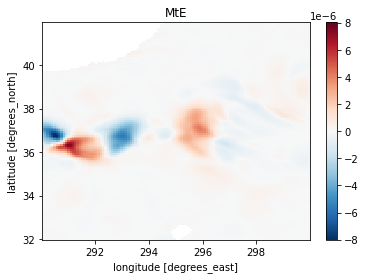

In [13]:
upTrans = up * xA
vpTrans = vp * yA
rpTrans = grid.interp(wp,'X',boundary='extend') * ds.rAw
Auup = (grid.interp(upTrans,'X',boundary='extend')
                * grid.interp(up,'X',boundary='extend')
        )
Avup = (grid.interp(vpTrans,'X',boundary='extend')
                * grid.interp(up,'Y',boundary='extend')
        )
Awup = (rpTrans
                * grid.interp(up,'Z',boundary='extend')
        )
rpTrans = grid.interp(wp,'Y',boundary='extend') * ds.rAs
Auvp = (grid.interp(upTrans,'Y',boundary='extend')
                * grid.interp(vp,'X',boundary='extend')
        )
Avvp = (grid.interp(vpTrans,'Y',boundary='extend')
                * grid.interp(vp,'Y',boundary='extend')
        )
Awvp = (rpTrans
                * grid.interp(vp,'Z',boundary='extend')
        )
Aut = ((grid.diff(Auup,'X',boundary='extend')
                + grid.diff(Avup,'Y',boundary='extend')
                - grid.diff(Awup,'Z',boundary='extend')
        ) / ds.drF/ds.rAw).isel(Z=[14,24])
Avt = ((grid.diff(Auvp,'X',boundary='extend')
                + grid.diff(Avvp,'Y',boundary='extend')
                - grid.diff(Awvp,'Z',boundary='extend')
        ) / ds.drF/ds.rAs).isel(Z=[14,24])
MtE = (grid.interp(ub.isel(Z=[14,24])*Aut,'X',boundary='extend')
               + grid.interp(vb.isel(Z=[14,24])*Avt,'Y',boundary='extend')
              ).isel(YC=slice(ng,-ng),XC=slice(ng,-ng)).reset_coords(drop=True)
fig, ax = plt.subplots()
MtE.isel(nmemb=0,time=0,Z=0).plot(ax=ax)
ax.set_title(r"MtE")
plt.show()

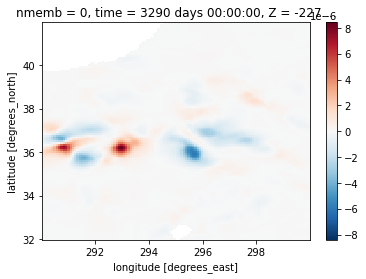

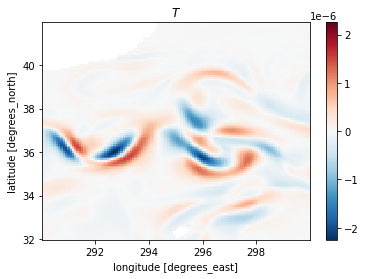

In [14]:
mmem = (up*ub
                + grid.interp(grid.interp(vp*vb,'Y',boundary='extend'),
                              'X',boundary='extend') 
        )
mmem_x = upTrans*mmem
mmem = (grid.interp(grid.interp(up*ub,'X',boundary='extend'),
                            'Y',boundary='extend') 
                + vp*vb
        )
mmem_y = vpTrans*mmem
rTrans = wp * ds.rA
mmem = grid.interp(grid.interp(up*ub,'X',boundary='extend') 
                           + grid.interp(vp*vb,'Y',boundary='extend'),
                           'Z',boundary='extend'
        )
mmem_z = rTrans*mmem
Ammem = ((grid.diff(mmem_x,'X',boundary='extend')
                  + grid.diff(mmem_y,'Y',boundary='extend')
                  - grid.diff(mmem_z,'Z',boundary='extend')
        ) / ds.drF/ds.rA).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng)
                              ).reset_coords(drop=True)
(Ammem-MtE).isel(nmemb=0,time=0,Z=0).plot()
plt.show()
        
        
eke = .5*(grid.interp(up**2,'X',boundary='extend') 
                  + grid.interp(vp**2,'Y',boundary='extend')
                 )
Te = eke.isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng)
                     ).diff('time') / (5*86400.)
fig, ax = plt.subplots()
Te.isel(nmemb=0,time=0,Z=0).plot(ax=ax)
ax.set_title(r"$T$")
plt.show()

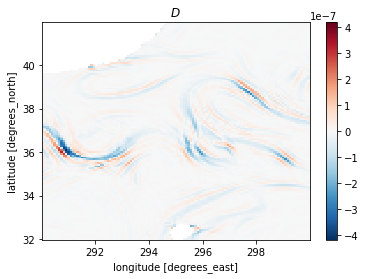

In [16]:
cosFacU = np.cos(ds.YC*2*np.pi/360.)
cosFacV = np.cos(ds.YG*2*np.pi/360.)
        
fZon = (ds.drF*ds.hFacC
            *grid.interp(ds.dyG,'X',boundary='fill')
            *grid.interp(ds.dxG,'Y',boundary='fill')**-1
            *grid.diff(up,'X',boundary='extend')
# #ifdef COSINEMETH_III
#      &   *sqCosFacU(J,bi,bj)
# #endif
# #ifdef ALLOW_OBCS
#      &   *maskInC(i,j,bi,bj)
# #endif
#            *deepFacC(k)        # dyF scaling factor
#            *recip_deepFacC(k)  # recip_dxF scaling factor
        )
        
fMer = (ds.drF*grid.interp(ds.hFacW,'Y',boundary='fill')
            *grid.interp(ds.dxG,'X',boundary='fill')
            *grid.interp(ds.dyG,'Y',boundary='fill')**-1
            *grid.diff(up,'Y',boundary='fill')
# #if (defined (ISOTROPIC_COS_SCALING) && defined (COSINEMETH_III))
#      &   *sqCosFacV(J,bi,bj)
# #endif
#            *deepFacC(k)        # dxV scaling factor
#            *recip_deepFacC(k)  # recip_dyU scaling factor
        )
        
del2u = (ds.drF**-1*ds.hFacW**-1
             *ds.rAw**-1
#              *recip_deepFac2C(k)
             *( grid.diff(fZon,'X',boundary='extend')
               +grid.diff(fMer,'Y',boundary='extend')
              ).where(ds.maskW!=0.)
        )

xViscFluxU = (grid.interp(ds.dyG,'X',boundary='fill')*ds.drF*ds.hFacC
          *(
            -Kh*grid.diff(up,'X',boundary='extend')
#             *cosFacU
            +K4*grid.diff(del2u,'X',boundary='extend')
# #ifdef COSINEMETH_III
#             *sqCosFacU(J,bi,bj)
# #else
#             *cosFacU
# #endif
           )*grid.interp(ds.dxG,'Y',boundary='fill')**-1
#            *deepFacC(k)        # dyF scaling factor
#            *recip_deepFacC(k)  # recip_dxF scaling factor
        )
        
yViscFluxU = (grid.interp(ds.dxG,'X',boundary='extend')
                      *ds.drF*grid.interp(ds.hFacW,'Y',boundary='fill')
          *(
            -Kh*grid.diff(up,'Y',boundary='extend')
# #ifdef ISOTROPIC_COS_SCALING
#             *cosFacV(J,bi,bj)
# #endif
            +K4*grid.diff(del2u,'Y',boundary='extend')
# #ifdef ISOTROPIC_COS_SCALING
#    #ifdef COSINEMETH_III
#             *sqCosFacV(J,bi,bj)
#    #else
#             *cosFacV
#    #endif
# #endif
           )*grid.interp(ds.dyG,'Y',boundary='extend')**-1
#            *deepFacC(k)        # dxV scaling factor
#            *recip_deepFacC(k)  # recip_dyU scaling factor
        )
#################################        
        
fZon = (ds.drF*grid.interp(ds.hFacS,'X',boundary='fill')
            *grid.interp(ds.dyG,'Y',boundary='extend')
            *grid.interp(ds.dxG,'X',boundary='extend')**-1
            *grid.diff(vp,'X',boundary='extend')
# #ifdef COSINEMETH_III
#         *sqCosFacV(J,bi,bj)
# #endif
#        *deepFacC(k)        # dyU scaling factor
#        *recip_deepFacC(k)  # recip_dxV scaling factor
        )
        
fMer = (ds.drF*ds.hFacC
            *grid.interp(ds.dxC,'X',boundary='extend')
            *grid.interp(ds.dyC,'Y',boundary='extend')**-1
            *grid.diff(vp,'Y',boundary='extend')
# #if (defined (ISOTROPIC_COS_SCALING) && defined (COSINEMETH_III))
#      &   *sqCosFacU(J,bi,bj)
# #endif
# #ifdef ALLOW_OBCS
#      &   *maskInC(i,j,bi,bj)
# #endif
#        *deepFacC(k)        # dxF scaling factor
#        *recip_deepFacC(k)  # recip_dyF scaling factor
        )
        
del2v = (ds.drF**-1*ds.hFacS**-1
           *ds.rAs**-1
#                  *recip_deepFac2C(k)
           *( grid.diff(fZon,'X',boundary='extend')
             +grid.diff(fMer,'Y',boundary='extend')
            ).where(ds.maskS!=0.)
# #ifdef ALLOW_OBCS
#      &    *maskInS(i,j,bi,bj)
# #endif
        )
        
xViscFluxV = (grid.interp(ds.dyC,'X',boundary='extend')
                      *ds.drF*grid.interp(ds.hFacS,'X',boundary='extend')
          *(
            -Kh*grid.diff(vp,'X',boundary='extend')
#             *cosFacV
            +K4*grid.diff(del2v,'X',boundary='extend')
# #ifdef COSINEMETH_III
#      &       *sqCosFacV(J,bi,bj)
# #else
#             *cosFacV
# #endif
           )*grid.interp(ds.dxC,'Y',boundary='extend')**-1
#            *deepFacC(k)        # dyU scaling factor
#            *recip_deepFacC(k)  # recip_dxV scaling factor
        )
        
yViscFluxV = (grid.interp(ds.dxC,'X',boundary='extend')
                      *ds.drF*ds.hFacC
          *(
            -Kh*grid.diff(vp,'Y',boundary='extend')
# #ifdef ISOTROPIC_COS_SCALING
#             *cosFacU
# #endif
            +K4*grid.diff(del2v,'Y',boundary='extend')
# #ifdef ISOTROPIC_COS_SCALING
#    #ifdef COSINEMETH_III
#             *sqCosFacU(J,bi,bj)
#    #else
#             *cosFacU
#    #endif
# #endif
           )*grid.interp(ds.dyC,'Y',boundary='extend')**-1
#            *deepFacC(k)        # dxF scaling factor
#            *recip_deepFacC(k)  # recip_dyF scaling factor
        )
#################################       
        
Dup_h = -((grid.diff(xViscFluxU
#                              *grid.interp(ds.dyC,'Y',boundary='extend')
                             ,'X',boundary='extend') 
                  +grid.diff(yViscFluxU
#                              *grid.interp(ds.dxG,'X',boundary='extend')
                             ,'Y',boundary='extend') 
                 ) / ds.rAw/ds.drF).reset_coords(drop=True)
Dvp_h = -((grid.diff(xViscFluxV
#                              *grid.interp(ds.dyG,'Y',boundary='extend')
                             ,'X',boundary='extend') 
                  +grid.diff(yViscFluxV
#                              *grid.interp(ds.dxC,'X',boundary='extend')
                             ,'Y',boundary='extend') 
                 ) / ds.rAs/ds.drF).reset_coords(drop=True)
#         Dup_h.isel(nmemb=0,time=0,Z=14).plot()
#         plt.show()
#         Dvp_h.isel(nmemb=0,time=0,Z=14).plot()
#         plt.show()
Dup_v = (grid.diff(grid.diff(up,'Z',boundary='extend',to='outer')
                                     / ds.drC*ds.rAw,
                           'Z',boundary='extend'
                          ) / ds.drF/ds.rAw
                ).reset_coords(drop=True) * Kr
Dvp_v = (grid.diff(grid.diff(vp,'Z',boundary='extend',to='outer')
                                     / ds.drC*ds.rAs,
                           'Z',boundary='extend'
                          ) / ds.drF/ds.rAs
                ).reset_coords(drop=True) * Kr
#         Dup_v.isel(nmemb=0,time=0,Z=14).plot()
#         plt.show()
#         Dvp_v.isel(nmemb=0,time=0,Z=14).plot()
#         plt.show()
Dup = Dup_h + Dup_v
Dvp = Dvp_h + Dvp_v
De = (grid.interp(up*Dup,'X',boundary='extend')
              + grid.interp(vp*Dvp,'Y',boundary='extend')
             ).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng))
fig, ax = plt.subplots()
De.isel(nmemb=0,time=0,Z=0).plot(ax=ax)
ax.set_title(r"$D$")
plt.show()

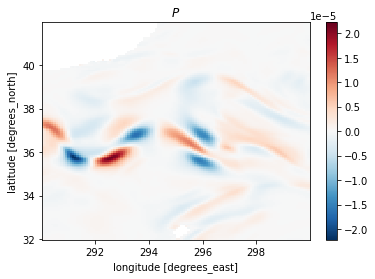

In [17]:
phip_y = (grid.diff(phip,'Y',boundary='extend')
                  / ds.dyC
                 ).reset_coords(drop=True)
phip_x = (grid.diff(phip,'X',boundary='extend')
                  / ds.dxC
                 ).reset_coords(drop=True)
Pe = -(grid.interp(up*phip_x,'X',boundary='extend')
               + grid.interp(vp*phip_y,'Y',boundary='extend')
              ).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng))
fig, ax = plt.subplots()
Pe.isel(nmemb=0,time=0,Z=0).plot(ax=ax)
ax.set_title(r"$P$")
plt.show()

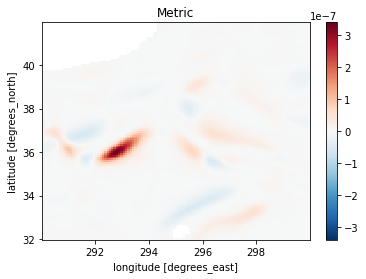

In [11]:
rSphere = 6.37e6
tanPhiAtU = np.tan(ds.YC*2*np.pi/360.)
tanPhiAtV = np.tan(ds.YG*2*np.pi/360.)
uMetric = (
         up*rSphere**-1
         *( grid.interp(grid.interp(vp,'X',boundary='extend'),'Y',boundary='extend')
          )*tanPhiAtU
        )

vMetric = (
         vp*rSphere**-1
         *( grid.interp(grid.interp(up,'Y',boundary='extend'),'X',boundary='extend')
          )*tanPhiAtV
        )

Me = (grid.interp(up*uMetric,'X',boundary='extend') 
      + grid.interp(vp*vMetric,'Y',boundary='extend')
     ).isel(Z=[14,24],YC=slice(ng,-ng),XC=slice(ng,-ng))
fig, ax = plt.subplots()
Me.isel(nmemb=0,time=0,Z=0).plot(ax=ax)
ax.set_title(r"Metric")
plt.show()

/tank/users/tuchida/miniconda3/envs/py39/lib/python3.9/site-packages/dask/array/core.py:4369: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(


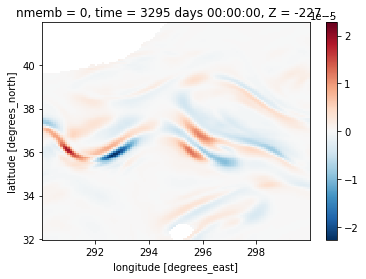

In [19]:
(Te + (Ae + (Ammem-MtE) - Pe - De).isel(time=0)).isel(nmemb=0,Z=0).plot()